In [1]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
from utils import *
from functions import *
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture 
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import validation_curve

os.environ['TF_ENABLE_ONEDNN_OPTS']='0'

from sklearn.metrics import adjusted_mutual_info_score

import os
import scipy.io

from sklearn.decomposition import PCA

# Load dataset from file
folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'

# List all .mat files in the folder and load them
cnc_maps = scipy.io.loadmat(folder_path + 'cncMaps.mat')['cncMaps'][:80, :80, :]
esc_maps = scipy.io.loadmat(folder_path + 'escMaps.mat')['escMaps'][:80, :80, :]

# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols'][:80, :, :]
esc_polys = scipy.io.loadmat(folder_path + 'escPols.mat')['escPols'][:80, :, :]

def interpolate_polymers(polys):
    num_probes, num_coords, num_cells = polys.shape
    new_polys = np.zeros((num_probes, num_coords, num_cells))
    for c in range(num_cells):
        curr_cells = polys[:, :, c]
        for x in range(num_coords):
            curr_coords = curr_cells[:, x]
            missing_indices = np.isnan(curr_coords)
            valid_indices = ~missing_indices
            interp_coords = np.interp(np.flatnonzero(missing_indices), np.flatnonzero(valid_indices), curr_coords[valid_indices])
            new_polys[missing_indices, x, c] = interp_coords
            new_polys[valid_indices, x, c] = curr_coords[valid_indices]
    return new_polys

esc_polys_interp = interpolate_polymers(esc_polys)
cnc_polys_interp = interpolate_polymers(cnc_polys)

esc_maps_interp = np.array([squareform(pdist(esc_polys_interp[:, :, i])) for i in range(esc_polys_interp.shape[2])])
cnc_maps_interp = np.array([squareform(pdist(cnc_polys_interp[:, :, i])) for i in range(cnc_polys_interp.shape[2])])
esc_maps_interp_flat = np.array([x.flatten() for x in esc_maps_interp])
cnc_maps_interp_flat = np.array([x.flatten() for x in cnc_maps_interp])
all_maps_interp_flat = np.concatenate((esc_maps_interp_flat, cnc_maps_interp_flat), axis=0)

pca = PCA(n_components=2)
pca.fit(all_maps_interp_flat)
esc_maps_pca = pca.transform(esc_maps_interp_flat)
cnc_maps_pca = pca.transform(cnc_maps_interp_flat)

# Convert the principal components into a DataFrame
# add a column for the label
esc_df = pd.DataFrame(esc_maps_pca, columns=['PC1', 'PC2'])
esc_df['label'] = 'ESC'
cnc_df = pd.DataFrame(cnc_maps_pca, columns=['PC1', 'PC2'])
cnc_df['label'] = 'CNC'
all_df = pd.concat([esc_df, cnc_df], axis=0)

# Find 0.05 and 0.95 quantiles of PC1 and PC2 data
l = 0.01
u = 1-0.01

pc1_l = all_df['PC1'].quantile(l)
pc1_u = all_df['PC1'].quantile(u)
pc2_l = all_df['PC2'].quantile(l)
pc2_u = all_df['PC2'].quantile(u)

save_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/figures/20240812/'

pc1_grid = np.linspace(pc1_l, pc1_u, 50)
pc2_grid = np.linspace(pc2_l, pc2_u, 50)

# Generate combination of pc1 and pc2 values
pc1_grid, pc2_grid = np.meshgrid(pc1_grid, pc2_grid)

# put this into a dataframe
pc1_grid_flat = pc1_grid.flatten()
pc2_grid_flat = pc2_grid.flatten()
pc1_pc2_df = pd.DataFrame({'PC1': pc1_grid_flat, 'PC2': pc2_grid_flat})
pc1_pc2_df['label'] = 'metastructures'

2024-08-29 17:24:12.900815: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-29 17:24:12.942683: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
eigenvectors = pca.components_

In [3]:
pca_mean = pca.mean_

In [4]:
eigenvectors.shape

(2, 6400)

In [5]:
save_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/figures/20240821'

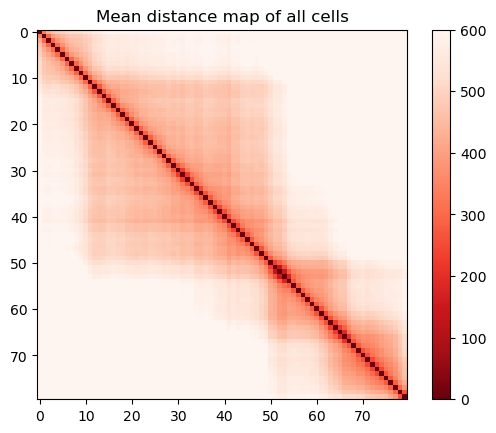

In [6]:
plt.imshow(pca_mean.reshape(80, 80), cmap='Reds_r', vmax=600)
plt.colorbar()
plt.title('Mean distance map of all cells')
plt.savefig(
    os.path.join(save_dir, 'mean_distance_map.png')
)

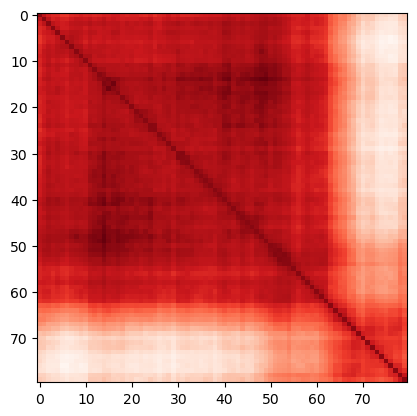

In [7]:
plt.imshow((pca_mean + 2E4*eigenvectors[0] - 2E4*eigenvectors[1]).reshape(80, 80), cmap='Reds_r')

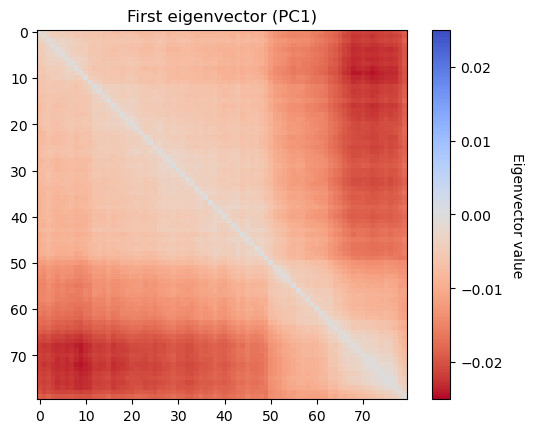

In [8]:
# Plot the first eigenvector
plt.imshow(eigenvectors[0].reshape(80, 80), cmap='coolwarm_r', vmin=-0.025, vmax=0.025)
# Add and label colorbar

# Add a colorbar
cbar = plt.colorbar()

# Set the colorbar label with rotation
cbar.set_label('Eigenvector value', rotation=270, labelpad=15)
plt.title('First eigenvector (PC1)')
plt.savefig(
    os.path.join(save_dir, 'first_eigenvector.png')
)

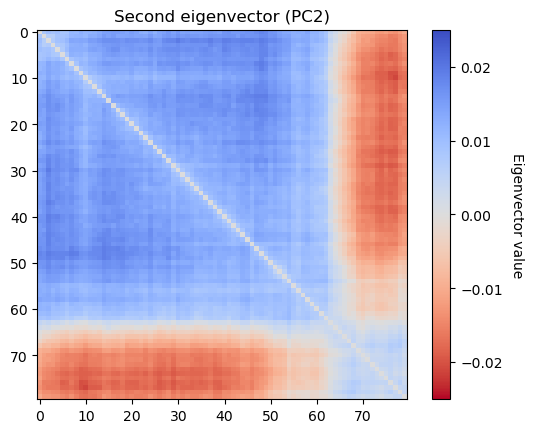

In [9]:
plt.imshow(eigenvectors[1].reshape(80, 80), cmap='coolwarm_r', vmin=-0.025, vmax=0.025)
plt.title('Second eigenvector (PC2)')
# Add a colorbar
cbar = plt.colorbar()

# Set the colorbar label with rotation
cbar.set_label('Eigenvector value', rotation=270, labelpad=15)
plt.title('Second eigenvector (PC2)')
plt.savefig(
    os.path.join(save_dir, 'second_eigenvector.png')
)

In [10]:
v1 = eigenvectors[0].reshape(80, 80)
v2 = eigenvectors[1].reshape(80, 80)

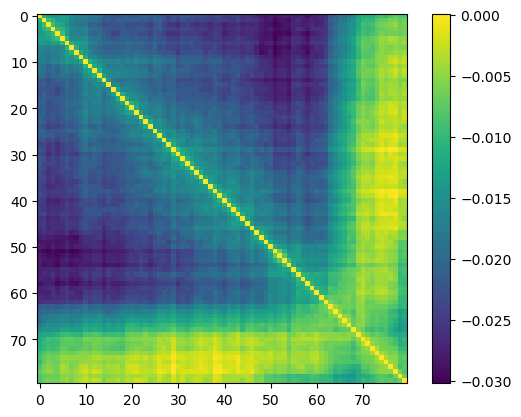

In [11]:
plt.imshow(v1-v2)
plt.colorbar()

In [12]:
def reconstruct_coordinates_from_edm(D):
    # Step 1: Convert distance matrix to squared distance matrix
    D2 = D ** 2
    
    # Step 2: Centering matrix
    n = D.shape[0]
    J = np.eye(n) - np.ones((n, n)) / n
    
    # Step 3: Compute Gram matrix
    B = -0.5 * J @ D2 @ J
    
    # Step 4: Eigenvalue decomposition
    eigvals, eigvecs = np.linalg.eigh(B)
    
    # Step 5: Select top 3 eigenvalues and corresponding eigenvectors
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    
    # Select the top 3 eigenvalues and their corresponding eigenvectors
    L = np.diag(np.sqrt(eigvals[:3]))
    V = eigvecs[:, :3]
    
    # Step 6: Construct the coordinates
    X = V @ L
    
    return X

In [13]:
# reconstruct_coordinates_from_edm(esc_maps_interp[0])

In [14]:
def load_weights(directory, num_metastructures):
    log_weights = []
    lp = []
    files = sorted(os.listdir(directory))[-4:]
    print(files)
    
    log_weights_d = []
    for file in files:
        log_weights_chain = []
        lp_chain = []
        with open('%s/%s'%(directory, file), newline='') as csvfile:
            reader = csv.DictReader(filter(lambda row: row[0]!='#', csvfile), )
            for row in reader:
                log_weights_row = [float(row["log_weights.%d"%i]) for i in range(1,num_metastructures+1)]
                lp_chain.append(float(row["lp__"]))
                log_weights_chain.append(log_weights_row)
        log_weights = np.array(log_weights_chain)
        lp_chain = np.array(lp_chain)
        log_weights_d.append(log_weights)
        lp.append(lp_chain)
    log_weights_d = np.array(log_weights_d)
    return log_weights_d 

common_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/20240812_WeightMCMC_PCA_metastructures_3'

stan_directory_esc = os.path.join(common_dir, 'ESC/stan_output')
stan_directory_cnc = os.path.join(common_dir, 'CNC/stan_output')
stan_directory_all = os.path.join(common_dir, 'all/stan_output')

esc_log_weights = load_weights(stan_directory_esc, 2500)
cnc_log_weights = load_weights(stan_directory_cnc, 2500)
# all_log_weights = load_weights(stan_directory_all, 2500)


['20240715_WeightOptimization-20240812175231_1.csv', '20240715_WeightOptimization-20240812175231_2.csv', '20240715_WeightOptimization-20240812175231_3.csv', '20240715_WeightOptimization-20240812175231_4.csv']
['20240715_WeightOptimization-20240812180729_1.csv', '20240715_WeightOptimization-20240812180729_2.csv', '20240715_WeightOptimization-20240812180729_3.csv', '20240715_WeightOptimization-20240812180729_4.csv']


In [66]:
esc_all_weights.shape

(4, 1000, 2500)

In [15]:
esc_all_weights = np.exp(np.array(esc_log_weights))
cnc_all_weights = np.exp(np.array(cnc_log_weights))

esc_weights_all = np.mean(esc_all_weights, axis=0)
cnc_weights_all = np.mean(cnc_all_weights, axis=0)

In [16]:
esc_entropy_all = np.array([scipy.stats.entropy(x) for x in esc_weights_all])
cnc_entropy_all = np.array([scipy.stats.entropy(x) for x in cnc_weights_all])

In [17]:
esc_entropy_df = pd.DataFrame({'entropy': esc_entropy_all, 'label': 'ESC'})
cnc_entropy_df = pd.DataFrame({'entropy': cnc_entropy_all, 'label': 'CNC'})

all_entropy_df = pd.concat([esc_entropy_df, cnc_entropy_df], axis=0)

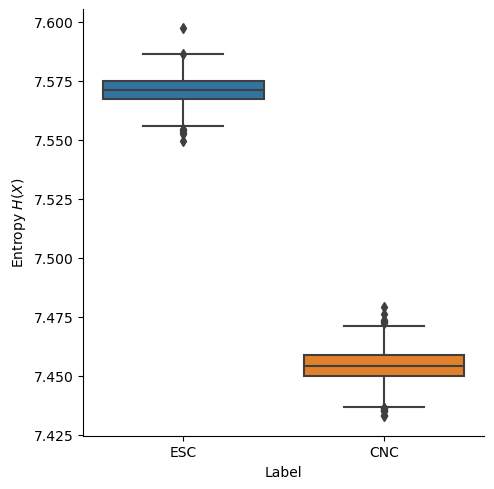

In [18]:
sns.catplot(x='label', y='entropy', data=all_entropy_df, kind='box')
plt.xlabel('Label')
plt.ylabel(r'Entropy $H(X)$')
plt.savefig(
    os.path.join(save_dir, 'entropy_boxplot_esc_cnc.png'), dpi=300, bbox_inches='tight'
)

In [78]:
esc_all_weights_grid = esc_all_weights.reshape(-1, 2500)
cnc_all_weights_grid = cnc_all_weights.reshape(-1, 2500)

In [79]:
esc_entropy_all_2 = np.array([scipy.stats.entropy(x) for x in esc_all_weights_grid])
cnc_entropy_all_2 = np.array([scipy.stats.entropy(x) for x in cnc_all_weights_grid])

In [80]:
esc_entropy_df_2 = pd.DataFrame({'entropy': esc_entropy_all_2, 'label': 'ESC'})
cnc_entropy_df_2 = pd.DataFrame({'entropy': cnc_entropy_all_2, 'label': 'CNC'})

all_entropy_df_2 = pd.concat([esc_entropy_df_2, cnc_entropy_df_2], axis=0)

Text(-8.305555555555555, 0.5, 'Entropy $H(X)$')

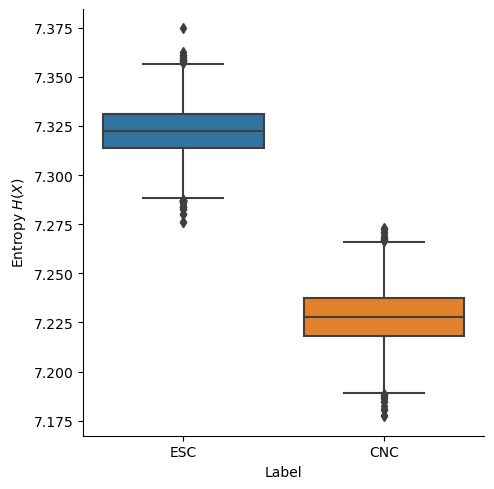

In [81]:
sns.catplot(x='label', y='entropy', data=all_entropy_df_2, kind='box')
plt.xlabel('Label')
plt.ylabel(r'Entropy $H(X)$')
# plt.savefig(
#     os.path.join(save_dir, 'entropy_boxplot_esc_cnc.png'), dpi=300, bbox_inches='tight'
# )

In [82]:
esc_all_weights_grid_50 = esc_all_weights.reshape(-1, 50, 50)
cnc_all_weights_grid_50 = cnc_all_weights.reshape(-1, 50, 50)

In [85]:
esc_ent_dist = [scipy.stats.entropy(x.reshape(-1)) for x in tqdm(esc_all_weights_grid_50)]
cnc_ent_dist = [scipy.stats.entropy(x.reshape(-1)) for x in tqdm(cnc_all_weights_grid_50)]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [ ]:
esc_PC1_entropy = np.array([scipy.stats.entropy(x[:, ]) for x in esc_all_weights_grid_50])